# CNN-LSTM with data preprocessing 

#### This notebook has been created by Tonmoy.

## (i) Importing the necessary packages

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Flatten,Dropout, MultiHeadAttention, Bidirectional
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape, LayerNormalization,GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

In [17]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [18]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

keras.backend.clear_session()


Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [38]:
class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        shape = tf.shape(inputs)
        batch_size, seq_len = shape[0], shape[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.position_embeddings(positions)
        return inputs + positions




def build_model(num_heads=2, input_shape=(250, 1, 22), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    # Add a PositionEmbedding layer
    x = PositionEmbedding(sequence_length=input_shape[0], output_dim=input_shape[-1])(inputs)
    # conv layer 1

    In1 = keras.Input(shape =(250,1,22) )
    c1 = Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu')(In1)
    p1 =  MaxPooling2D(pool_size=(2,1), padding='same')(c1) # Read the keras documentation
    b1 = BatchNormalization()(p1)
    d1 = Dropout(0.5)(b1)
    print(d1.shape)

    # Conv. block 2
    c2 = Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu')(d1)
    p2 =  MaxPooling2D(pool_size=(2,1), padding='same')(c2) # Read the keras documentation
    b2 = BatchNormalization()(p2)
    d2 = Dropout(0.5)(b2)
    print(d2.shape)

    # Conv. block 3
    c3 = Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu')(d2)
    p3 =  MaxPooling2D(pool_size=(2,1), padding='same')(c3) # Read the keras documentation
    b3 = BatchNormalization()(p3)
    d3 = Dropout(0.5)(b3)
    print (d3.shape)

    # Conv. block 4
    c4 = Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu')(d3)
    p4 =  MaxPooling2D(pool_size=(2,1), padding='same')(c4) # Read the keras documentation
    b4 = BatchNormalization()(p4)
    d4 = Dropout(0.5)(b4)


    # LSTM block
    lstm1 = Reshape((-1, 200))(d4)
    lstm1 = Bidirectional(LSTM(units=64, dropout=0.6, recurrent_dropout=0.1, return_sequences=True))(lstm1)
    lstm1 = LayerNormalization()(lstm1)

    # lstm2 = Reshape((-1, 100))(lstm1)
    lstm2 = Bidirectional(LSTM(units=10, dropout=0.6, recurrent_dropout=0.1, return_sequences=True))(lstm1)
    lstm2 = LayerNormalization()(lstm2)
    
    # Multi-head attention block
    query_inputs = lstm2
    key_inputs = lstm2
    value_inputs = lstm2
    multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=lstm2.shape[-1] // 4)(query_inputs, key_inputs, value_inputs)
    multi_head_attention = LayerNormalization(epsilon=1e-6)(multi_head_attention)
    multi_head_attention = GlobalAveragePooling1D()(multi_head_attention)

    # Add fully connected layers
    fc1 = Dense(64, activation='relu')(multi_head_attention)
    fc1_dropout = Dropout(rate=0.5)(fc1)
    fc2 = Dense(4, activation='softmax')(fc1_dropout)

    # Define the final model
    final_model = Model(inputs=In1, outputs=[fc2])
    final_model.summary()
    return final_model

## (iv)(CNN-LSTM) Defining the hyperparameters of the hybrid CNN-LSTM model

In [39]:
# Model parameters

epochs = 200
initial_learning_rate = 1e-3
decay_steps = 1000
decay_rate = 0.99

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

## (v)(CNN-LSTM) Compiling, training and validating the model

In [40]:
# Compiling the model
hybrid_cnn_lstm_model = build_model()
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])

# Training and validating the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # stops if not improving after 10 epochs
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=32,
                epochs=epochs,
                validation_data=(x_valid, y_valid), 
                verbose=True,
                callbacks = [callback])



(None, 125, 1, 25)
(None, 63, 1, 50)
(None, 32, 1, 100)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 250, 1, 25)   2775        ['input_12[0][0]']               
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 125, 1, 25)  0           ['conv2d_20[0][0]']              
 )                                                                                                
                                    

## (vi)(CNN-LSTM) Visualizing the accuracy and loss trajectory

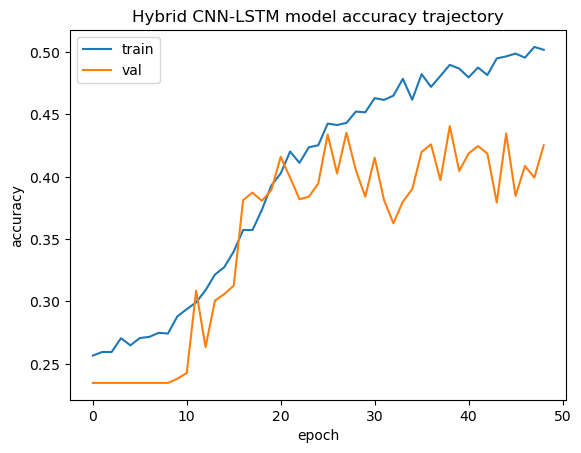

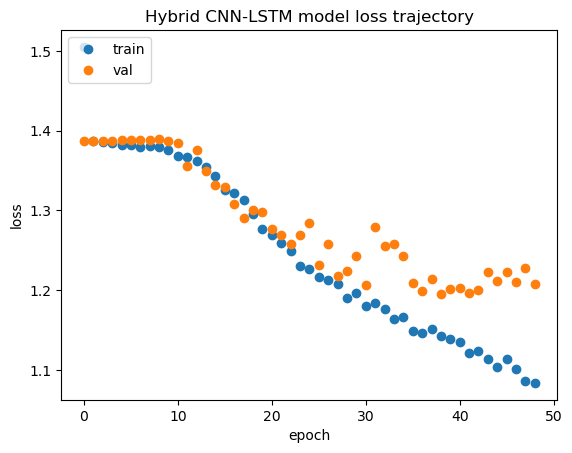

In [29]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN-LSTM) Testing the performance of the hybrid CNN-LSTM model on the held out test set

In [30]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.42268621921539307
